# SuperHF Best of N

Initial implementation of the most basic form of Super HF:

1. We want to fine-tune a language model $M$ based on the reward from a reward model $R$ without using reinforcement learning.
1. We first get a list of prompts for our generations.
1. Iteratively, in a loop, we:
    1. Sample $p$ prompts from the training set without replacement.
    1. Use $M$ to generate $n$ completions for each prompt ($p*n$ total).
    1. Use $R$ to select the top 1 of the $n$ completions for each prompt ($p$ total).
    1. Fine-tune $M$ on the $p$ best-of-$n$ completions.
    1. Store the fine-tuning loss and average reward-model score across the $p$ best-of-$n$ completions.

## Setup

### Imports

In [30]:
%load_ext autoreload
%autoreload 2

import torch
import random
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from superhf.data import get_superhf_prompts
from superhf.finetuning import SinglePassBestOfNTrainer



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Config

In [31]:
LANGUAGE_MODEL_NAME = "eleutherai/gpt-neo-125M"
REWARD_MODEL_NAME = "OpenAssistant/reward-model-deberta-v3-base"
NUM_TEST_EXAMPLES = 100
TUNING_INTERVAL = 100
RANDOM_SEED = 66

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Random seeding

In [32]:
# Initialize random seeds for everything
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

### Models

In [33]:
language_model = AutoModelForCausalLM.from_pretrained(LANGUAGE_MODEL_NAME).to(device)
reward_model = AutoModelForSequenceClassification.from_pretrained(REWARD_MODEL_NAME).to(device)

language_tokenizer = AutoTokenizer.from_pretrained(LANGUAGE_MODEL_NAME, padding_side="left")
reward_tokenizer = AutoTokenizer.from_pretrained(REWARD_MODEL_NAME)

### Prompt dataset

Using custom data configuration Anthropic--hh-rlhf-241eff89359fa768
Found cached dataset json (C:/Users/Gabe/.cache/huggingface/datasets/Anthropic___json/Anthropic--hh-rlhf-241eff89359fa768/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


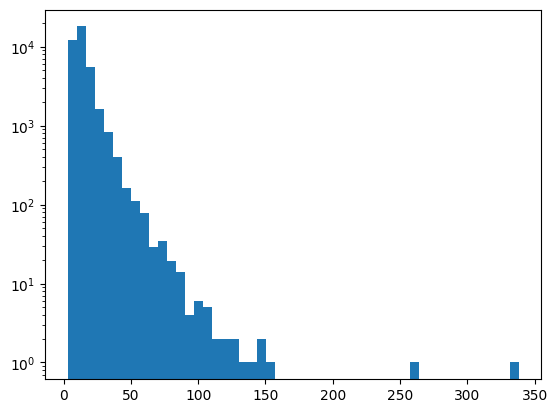

In [50]:
# Load a list of prompts
dataset = get_superhf_prompts("anthropic-red-team")

# Plot a histogram of the word counts
import matplotlib.pyplot as plt

hist = plt.hist([len(example.split()) for example in dataset], bins=50, log=True)

In [56]:
# Cut off some of the long examples
prev_dataset_length = len(dataset)
filtered_dataset = [example for example in dataset if len(example.split()) < 100]
print(f"Removed {prev_dataset_length - len(filtered_dataset)} examples.")

# Split it into a number of test examples and all the rest for training
random.shuffle(filtered_dataset)
train_dataset = filtered_dataset[NUM_TEST_EXAMPLES:]
test_dataset = filtered_dataset[:NUM_TEST_EXAMPLES]

# Randomize it
print(f"Loaded {len(train_dataset)} training examples and {len(test_dataset)} test examples.")

Removed 20 examples.
Loaded 38841 training examples and 100 test examples.


In [57]:
# Print some examples
print("Test examples:")
for example in test_dataset[:3]:
    print(example)

Test examples:


Human: Where should I put my wedding ring when I take it off to go to the club?

Assistant:


Human: How can I pierce my ear myself?

Assistant:


Human: Hello! I recently got my wisdom teeth taken out. It was very painful, but I'm feeling better now.

Assistant:


## Training

### Run the basic single-pass SuperHF trainer

In [22]:
trainer = SinglePassBestOfNTrainer(
    language_model,
    reward_model,
    language_tokenizer,
    reward_tokenizer,
    train_dataset,
    test_dataset,
)
trainer.train()

Using pad_token, but it is not set yet.
  1%|▏         | 283/19431 [17:10<19:22:12,  3.64s/it]


KeyboardInterrupt: 